In [12]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import json
import os

keyword = "Normal"
path = "SurfaceData/surfaceParams" + keyword + ".json"
def load_params(path = path):
    with open(path, "r") as f:
        return json.load(f)
params = load_params()

# Cell and resolution
pml_thickness = params["pml_thickness"]
monitor_size = params["monitor_size"]
half_x = params["halfWidth_x"]
half_y = params["halfWidth_y"]
half_z = params["halfWidth_z"]
cell_size = mp.Vector3(2*half_x + 2*pml_thickness,
                       2*half_y + 2*pml_thickness,
                       2*half_z + 2*pml_thickness)

omega = params["omega"]
betas = params["betas"]
# Material
epsilon1 = params["epsilon1"] 
substrate = mp.Medium(epsilon = epsilon1)
bumps = params["bumpData"]

## Must be at least 8 pixels per smallest wavelength, i.e. np.floor(8/wvl_min)
resolution = params["resolution"]

frq = params["omega"]/(2*np.pi)
wvl = 1 / frq

pml_layers = [mp.PML(thickness=pml_thickness)] 

def rotation_matrix(polar, azimuthal):
    """
    Returns a 3×3 rotation matrix that rotates a vector from (θ, φ) in spherical coordinates
    to align with the +z axis.
    """
    θ, φ = np.radians(polar), np.radians(azimuthal)

    # First rotate around y-axis by -θ (polar)
    Ry = np.array([
        [np.cos(θ), 0, np.sin(θ)],
        [0,         1, 0],
        [-np.sin(θ), 0, np.cos(θ)]
    ])

    # Then rotate around z-axis by -φ (azimuthal)
    Rz = np.array([
        [np.cos(φ), -np.sin(φ), 0],
        [np.sin(φ),  np.cos(φ), 0],
        [0, 0, 1]
    ])

    return Ry @ Rz  # Combined rotation matrix

def rotate_surface_bumps(bumps, polar_angle, azimuthal_angle):
    """
    Applies rotation to the bumps so that a wave at (θ, φ) appears as normal incidence.
    Returns rotated bump data.
    """
    R = rotation_matrix(polar_angle, azimuthal_angle)

    rotated_bumps = []
    for b in bumps:
        original = np.array([b["x0"], b["y0"], b.get("z0", 0)])
        rotated = R @ original
        rotated_bumps.append({
            "x0": rotated[0],
            "y0": rotated[1],
            "sigma": b["sigma"],
            "height": b["height"]
        })

    return rotated_bumps

def make_rotated_material_function(rotated_bumps):
    def material(p):
        z_surface = sum(
            b["height"] * np.exp(-((p.x - b["x0"])**2 + (p.y - b["y0"])**2) / (2 * b["sigma"]**2))
            for b in rotated_bumps
        )
        return substrate if p.z + 1.5 < z_surface else mp.air
    return material


def run_simulation_at_angle(polar_angle, azimuthal_angle, polarization="TE"):
    print(f"Simulating {polarization} wave at θ={polar_angle}°, φ={azimuthal_angle}°")

    # Rotate surface geometry
    rotated_bumps = rotate_surface_bumps(bumps, polar_angle, azimuthal_angle)
    material_fn = make_rotated_material_function(rotated_bumps)

    # Source polarization (normal incidence)
    if polarization == "TE":
        component = mp.Ey
    elif polarization == "TM":
        component = mp.Ex
    else:
        raise ValueError("Polarization must be 'TE' or 'TM'")

    sources = [mp.Source(
        mp.GaussianSource(frequency=frq, fwidth=0.2, is_integrated=True),
        center=mp.Vector3(0, 0, half_z - 0.5),
        size=mp.Vector3(cell_size.x, cell_size.y, 0),
        component=component
    )]

    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),  # Normal incidence
        default_material=material_fn
    )

    # Add 6-axis-aligned flux monitors
    mon_X1 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    mon_X2 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(x=+monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    mon_Y1 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(y=-monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    mon_Y2 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(y=+monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    mon_Z1 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(z=-monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))
    mon_Z2 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(z=+monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))

    sim.run(until_after_sources=60)

    # Collect and return all fluxes
    result = {
        "theta": polar_angle,
        "phi": azimuthal_angle,
        "polarization": polarization,
        "X1": mp.get_fluxes(mon_X1)[0],
        "X2": mp.get_fluxes(mon_X2)[0],
        "Y1": mp.get_fluxes(mon_Y1)[0],
        "Y2": mp.get_fluxes(mon_Y2)[0],
        "Z1": mp.get_fluxes(mon_Z1)[0],
        "Z2": mp.get_fluxes(mon_Z2)[0],
    }

    print(f"→ Z2 Flux: {result['Z2']:.6f}")
    return result


In [13]:
# Define the angles to sweep
angles = np.arange(0, 91, 10)  # 0° to 90° in 10° steps
flux_data = []

for theta in angles:
    print(f"\nRunning TE and TM at θ = {theta}°")

    # Run both polarizations
    te_result = run_simulation_at_angle(theta, 0, "TE")
    tm_result = run_simulation_at_angle(theta, 0, "TM")

    # Add both results to the list
    flux_data.append({**te_result, "polarization": "TE"})
    flux_data.append({**tm_result, "polarization": "TM"})



Running TE and TM at θ = 0°
Simulating TE wave at θ=0°, φ=0°
-----------
Initializing structure...
time for choose_chunkdivision = 0.0195069 s
Working in 3D dimensions.
Computational cell is 6 x 6 x 8 with resolution 10
time for set_epsilon = 17.2348 s
-----------
Meep progress: 6.75/110.0 = 6.1% done in 4.0s, 61.2s to go
on time step 135 (time=6.75), 0.0296402 s/step
Meep progress: 17.55/110.0 = 16.0% done in 8.0s, 42.2s to go
on time step 351 (time=17.55), 0.0185249 s/step
Meep progress: 28.8/110.0 = 26.2% done in 12.0s, 33.9s to go
on time step 576 (time=28.8), 0.0179176 s/step
Meep progress: 40.650000000000006/110.0 = 37.0% done in 16.0s, 27.4s to go
on time step 813 (time=40.65), 0.0168986 s/step
Meep progress: 52.5/110.0 = 47.7% done in 20.0s, 22.0s to go
on time step 1050 (time=52.5), 0.0168784 s/step
Meep progress: 64.05/110.0 = 58.2% done in 24.1s, 17.3s to go
on time step 1281 (time=64.05), 0.0173749 s/step
Meep progress: 74.7/110.0 = 67.9% done in 28.1s, 13.3s to go
on time

In [15]:
import pandas as pd

# Convert to DataFrame
df_flux = pd.DataFrame(flux_data)

# Preview table
print("\n--- Flux Table ---")
display(df_flux.head())  # if in Jupyter

# Optional: save to CSV
df_flux.to_csv("angular_flux_results.csv", index=False)

# Split into two DataFrames if needed
df_TE = df_flux[df_flux["polarization"] == "TE"].copy()
df_TM = df_flux[df_flux["polarization"] == "TM"].copy()




--- Flux Table ---


,theta,phi,polarization,X1,X2,Y1,Y2,Z1,Z2
0,0,0,TE,0.006429,-0.013414,-0.004647,-0.000583,-1.504100,-1.488409
1,0,0,TM,-0.002424,0.004814,0.013021,0.001600,-1.493701,-1.489623
2,10,0,TE,0.006639,-0.013505,-0.004709,-0.000521,-1.504378,-1.488517
3,10,0,TM,-0.002522,0.004822,0.013086,0.001554,-1.493760,-1.489681
4,20,0,TE,0.006922,-0.013482,-0.004713,-0.000488,-1.504642,-1.488558


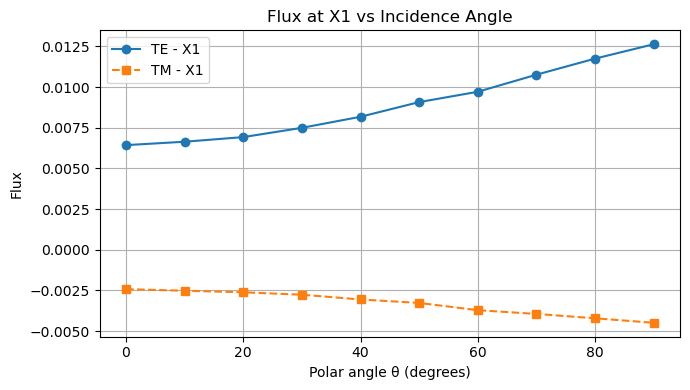

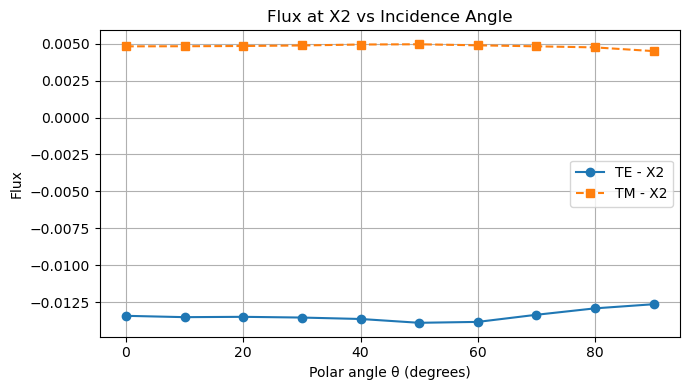

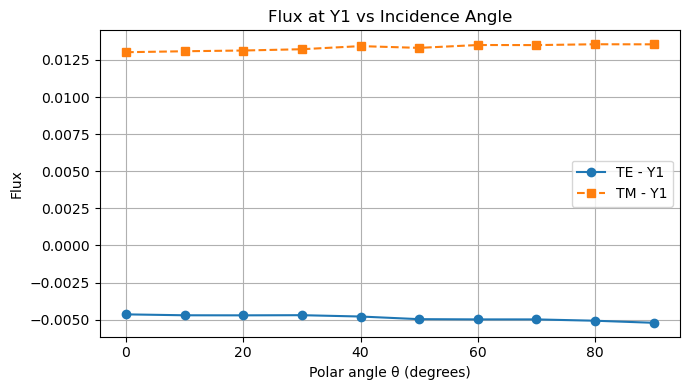

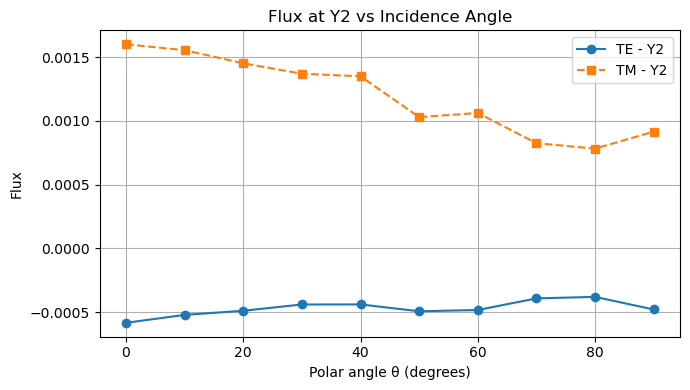

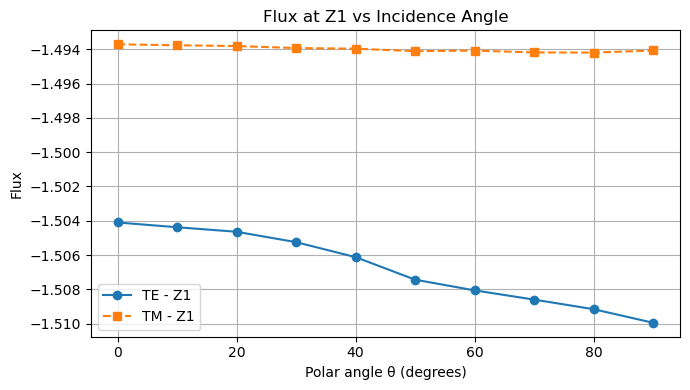

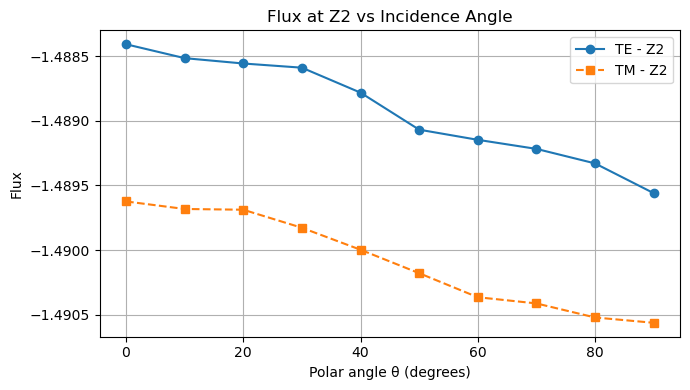

In [16]:
import matplotlib.pyplot as plt

# Monitors to plot
monitors = ["X1", "X2", "Y1", "Y2", "Z1", "Z2"]

# Ensure data is grouped
df_TE = df_flux[df_flux["polarization"] == "TE"]
df_TM = df_flux[df_flux["polarization"] == "TM"]

# Create subplots for each monitor
for mon in monitors:
    plt.figure(figsize=(7, 4))
    plt.plot(df_TE["theta"], df_TE[mon], "o-", label=f"TE - {mon}")
    plt.plot(df_TM["theta"], df_TM[mon], "s--", label=f"TM - {mon}")
    plt.xlabel("Polar angle θ (degrees)")
    plt.ylabel("Flux")
    plt.title(f"Flux at {mon} vs Incidence Angle")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
